<div align="center">

# Exercise Sheet 4: Data Science Methods  
## Technische Universität München 
### Winter semester 2024-2025

</div>


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## 1. Exercise: Likelihood Ratio Test (LRT)

In [2]:
# Define global variables
S0 = 60
tau = 5

### 1.1  Determine the global best fit for $S$ and $B$, i.e. the value of the MLEs $\hat{S}_{\text{MLE}}$ and $\hat{B}_{\text{MLE}}$ with no restrictions at the observed values $n_{\text{on}} = 105$, $n_{\text{off}} = 265$.

In [3]:
n_on = 105
n_off = 265

# MLE of S. This is just the derivative of the likelihood (eq. (3) in the exercise sheet) wrt to S. Then set dL/dS = 0 and solve for S. 
def S_MLE(n_on, n_off):
    return (n_on - n_off/tau)

# MLE of B. Same procedure as for S.
def B_MLE(n_off):
    return n_off / tau

def Var_S_MLE(S, B):
    return (S + B * (1 + 1/tau))

def Var_B_MLE(B):
    return B / tau

print(f"S_MLE = {S_MLE(n_on, n_off)}.")
print(f"B_MLE = {B_MLE(n_off)}.")

S_MLE = 52.0.
B_MLE = 53.0.


###  1.2 Illustrate the distribution of the MLEs $\hat{S}_{\text{MLE}}$ and $\hat{B}_{\text{MLE}}$.

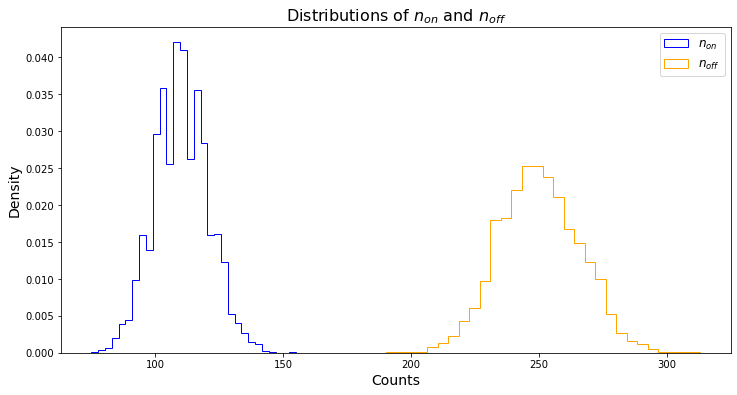

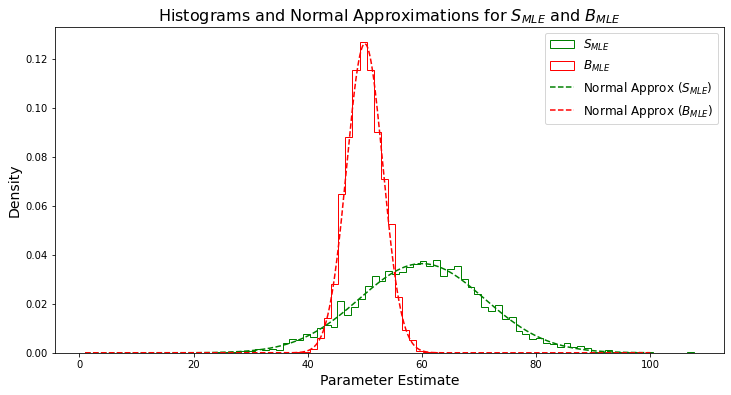

In [4]:
N_sample = 5_000
S_hypo = S0
B_hypo = 50
n_on_arr  = sp.stats.poisson.rvs(mu=(S_hypo + B_hypo), size=N_sample)
n_off_arr = sp.stats.poisson.rvs(mu=(tau*B_hypo), size=N_sample)
S_MLE_arr = S_MLE(n_on_arr, n_off_arr)
B_MLE_arr = B_MLE(n_off_arr)

plt.figure(figsize=(12, 6))

# First histogram just to check the distribution of n_on_arr and n_off_arr
plt.hist(n_on_arr, bins=30, density=True, histtype='step', label=r'$n_{on}$', color='blue')
plt.hist(n_off_arr, bins=30, density=True, histtype='step', label=r'$n_{off}$', color='orange')

plt.title(r'Distributions of $n_{on}$ and $n_{off}$', fontsize=16)
plt.xlabel('Counts', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.show()

# Define figure size for the second set of histograms
plt.figure(figsize=(12, 6))

# Second histogram: S_MLE_arr and B_MLE_arr
plt.hist(S_MLE_arr, bins=70, density=True, histtype='step', label=r'$S_{MLE}$', color='green')
plt.hist(B_MLE_arr, bins=20, density=True, histtype='step', label=r'$B_{MLE}$', color='red')

# Overlay normal distributions
X = np.linspace(1, 100, 1000)
plt.plot(X, sp.stats.norm.pdf(X, loc=S0, scale=Var_S_MLE(S0, B_hypo)**0.5), 
         label=r'Normal Approx ($S_{MLE}$)', color='green', linestyle='dashed')
plt.plot(X, sp.stats.norm.pdf(X, loc=B_hypo, scale=Var_B_MLE(B_hypo)**0.5), 
         label=r'Normal Approx ($B_{MLE}$)', color='red', linestyle='dashed')

plt.title(r'Histograms and Normal Approximations for $S_{MLE}$ and $B_{MLE}$', fontsize=16)
plt.xlabel('Parameter Estimate', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.show()


### 1.3 Determine the MLE $\hat{\hat{B}}_{\text{MLE}}$, given the null hypothesis $H_0$.

In [5]:
def B_MLE_H0(n_on, n_off, S0=S0):
    n_on = np.array(n_on)
    n_off = np.array(n_off)
    
    # Coefficients of the quadratic equation
    a = (1 + tau)
    b = (S0 * (1 + tau) - (n_on + n_off))
    c = - S0 * n_off
    
    # Calculate the discriminant
    discriminant = b**2 - 4 * a * c
    result = np.full_like(discriminant, np.nan, dtype=np.float64)
    mask1 = discriminant > 0
    result[mask1] = (-b[mask1] + np.sqrt(discriminant[mask1])) / (2 * a)
    mask2 = discriminant == 0
    result[mask2] = -b[mask2] / (2 * a)
    return result


print(rf"MLE of B, given the null hypothesis H0: {B_MLE_H0(n_on, n_off)}")

MLE of B, given the null hypothesis H0: 52.318228637144955


### 1.4 Construct the LRT and plot it against $\hat{S}_{\text{MLE}}$ to verify the relation $\lambda_{S_0} = \frac{\left(\hat{S}_{\text{MLE}} - S_0\right)^2}{\sigma^2_{\hat{S}_{\text{MLE}}}}$.

In [6]:
# Define the log-likelihood function (LLH):
def LLH(n_on, n_off, S, B):
    n_on = np.array(n_on)
    n_off = np.array(n_off)
    # sp.special.gammaln(n + 1) = log(n!) but does not evalueate to inf for large numbers
    P1 = n_on*np.log(S + B) - sp.special.gammaln(n_on + 1) - (S + B) 
    P2 = n_off*np.log(tau*B) - sp.special.gammaln(n_off + 1) - tau*B
    return P1 + P2 

# Define the Likelihood Ratio Test (LRT)
def LRT(n_on, n_off, S=S0):
    B_MLE_H0_sol = B_MLE_H0(n_on, n_off, S0=S)
    S_MLE_sol = S_MLE(n_on, n_off)
    B_MLE_sol = B_MLE(n_off)
    l1 = LLH(n_on, n_off, S, B_MLE_H0_sol)
    l2 = LLH(n_on, n_off, S_MLE_sol, B_MLE_sol)
    return -2 * (l1 - l2)

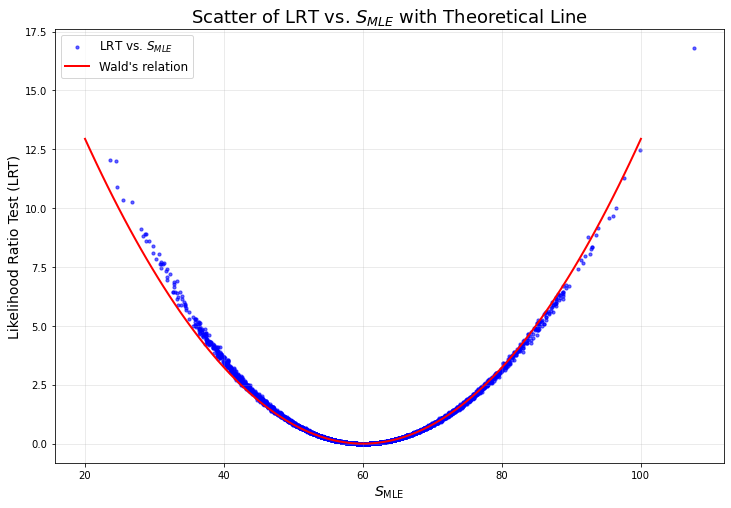

In [7]:
LRT_arr = LRT(n_on_arr, n_off_arr, S0) # Assuming further the null hypothesis H0. Wald's relation is independent of the nuisance parameter B, so we choose what we had before B = B_hypo = 50.

plt.figure(figsize=(12, 8))

# Scatter plot: S_MLE_arr vs. LRT_arr
plt.scatter(S_MLE_arr, LRT_arr, color='blue', alpha=0.6, label=r'LRT vs. $S_{MLE}$', s=10)

# Overlay line: Theoretical relationship
X = np.linspace(20, 100, 100)
Y = (S_hypo - X)**2/Var_S_MLE(S_hypo, B_MLE(n_off))
plt.plot(X, Y, color='red', linewidth=2, label=r"Wald's relation")

plt.title(r'Scatter of LRT vs. $S_{MLE}$ with Theoretical Line', fontsize=18)
plt.xlabel(r'$S_{\mathrm{MLE}}$', fontsize=14)
plt.ylabel('Likelihood Ratio Test (LRT)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(alpha=0.3)
plt.show()

### 1.5 According to Wilk's theorem, the LRT is distributed according to $\sim \chi^2_k$ under the null hypothesis $H_0$, where $k$ is the difference in the dimensionality of the alternative and null hypotheses. Show that this indeed holds via MC sampling. For a fixed size $\alpha = 0.05$, can we reject $H_0$?

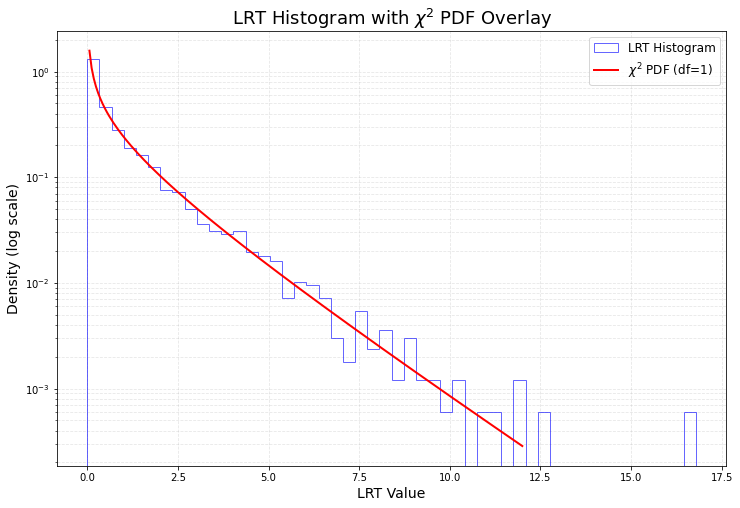

In [8]:
plt.figure(figsize=(12, 8))

# Histogram of LRT_arr
plt.hist(LRT_arr, bins=50, density=True, color='blue', alpha=0.6, label='LRT Histogram', histtype='step')

# Overlay chi-squared distribution (df=1)
X = np.linspace(0, 12, 200)
plt.plot(X, sp.stats.chi2.pdf(X, df=1), color='red', linewidth=2, label=r'$\chi^2$ PDF (df=1)')

plt.yscale('log')
plt.title('LRT Histogram with $\chi^2$ PDF Overlay', fontsize=18)
plt.xlabel('LRT Value', fontsize=14)
plt.ylabel('Density (log scale)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3, which='both', linestyle='--')
plt.show()

# Now, in order to reject or not H0, we need to determine the 

In [9]:
alpha = 0.05 # Given significance level

# We can determine the cutoff-value of the statistic, here LRT, that according to Wilk's theorem we know its distribution, given H0. 
t0 = sp.stats.chi2.ppf(1 - alpha, df=1) # cutoff
Tobs = LRT(n_on, n_off) # observed value of the statistic
print(f"Cutoff corresponding to alpha = {alpha}: {t0}. Observed value: {Tobs}. Hence, we do not reject the null hypothesis S0 = {S0}.")

# Or we can compute the p-value and compare it with the significance level alpha
pvalue = 1 - sp.stats.chi2.cdf(Tobs, df=1)
print(f"P-value: {pvalue}. Since this is larger than the significance level {alpha}, we cannot reject the null hypothesis S0 = {S0}.")

Cutoff corresponding to alpha = 0.05: 3.841458820694124. Observed value: 0.5317651386037596. Hence, we do not reject the null hypothesis S0 = 60.
P-value: 0.4658657025465318. Since this is larger than the significance level 0.05, we cannot reject the null hypothesis S0 = 60.


### 1.6 Furthermore, the LRT follows a non-central $\chi^2_{\text{nc}}$ distribution with non-central parameter $\Lambda^2_{S'} = \frac{\left(S' - S_0\right)^2}{\sigma^2_{\hat{S}_{\text{MLE}}}}$ under the alternative hypothesis. Illustrate this by assuming, say, $S' = \hat{S}_{\text{MLE}}$, $B' = \hat{B}_{\text{MLE}}$.

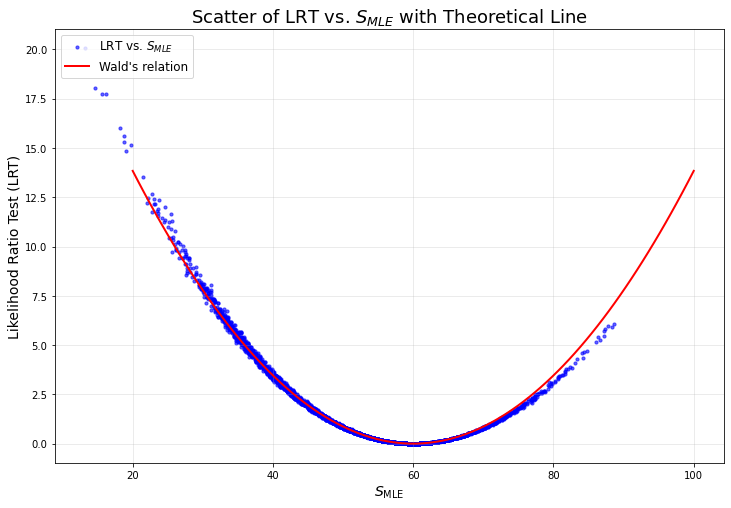

In [10]:

N_sample = 5_000
# Now we are assuming an alternative hypothesis S = S_MLE, B = B_MLE (given our observed values n_on, n_off)
S_hypo = S_MLE(n_on, n_off)
B_hypo = B_MLE(n_off)
n_on_arr  = sp.stats.poisson.rvs(mu=(S_hypo + B_hypo), size=N_sample)
n_off_arr = sp.stats.poisson.rvs(mu=(tau*B_hypo), size=N_sample)

S_MLE_arr = S_MLE(n_on_arr, n_off_arr)
LRT_arr = LRT(n_on_arr, n_off_arr, S0)

plt.figure(figsize=(12, 8))

# Scatter plot: S_MLE_arr vs. LRT_arr
plt.scatter(S_MLE_arr, LRT_arr, color='blue', alpha=0.6, label=r'LRT vs. $S_{MLE}$', s=10)

# Overlay line: Theoretical relationship
X = np.linspace(20, 100, 100)
Y = (S0 - X)**2/Var_S_MLE(S_hypo, B_hypo)
plt.plot(X, Y, color='red', linewidth=2, label=r"Wald's relation")

plt.title(r'Scatter of LRT vs. $S_{MLE}$ with Theoretical Line', fontsize=18)
plt.xlabel(r'$S_{\mathrm{MLE}}$', fontsize=14)
plt.ylabel('Likelihood Ratio Test (LRT)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(alpha=0.3)
plt.show()

## 2. Exercise: Neyman Construction

### Now imagine that a random variable $X$ is normally distributed $X \sim \mathcal{N}(\mu_0, \sigma)$, with known variance $\sigma^2 = 1$ and unknown (to us) expectation value $\mu_0 = 5$

### 2.1 Construct a CI with $\alpha = \beta = 0.025$ (central CI at $95\%$ CL), if we observe $X_{\text{obs}} = 4.5$ (here we are using the statistic $T(X) = X$, i.e. the observation itself).

In [11]:
# Define function to find numerically the lower and upper value of the CI, respectively

def get_CI_lower(alpha, Tobs_f, cdfun, a0, T_dep_a=False): # a0 is initial guess
    if T_dep_a:
        f = lambda a : cdfun(Tobs_f(a), a) - (1 - alpha)
    else:
        f = lambda a : cdfun(Tobs_f, a) - (1 - alpha)
    sol = sp.optimize.fsolve(f, a0)
    return sol[0]

def get_CI_upper(beta, Tobs_f, cdfun, b0, T_dep_b=False): # a0 is initial guess
    if T_dep_b:
        f = lambda b : cdfun(Tobs_f(b), b) - beta
    else:
        f = lambda b : cdfun(Tobs_f, b) - beta
    sol = sp.optimize.fsolve(f, b0)
    return sol[0]

In [12]:
%time
x = 4.5
Tobs_f = x
cdfun = lambda Tobs, param : sp.stats.norm.cdf(Tobs, loc=param, scale=1)
alpha = 0.025
beta = alpha
theta_low = get_CI_lower(alpha, Tobs_f, cdfun, 4.5)
theta_up = get_CI_upper(beta, Tobs_f, cdfun, 4.5)

# CI
print(f"Confidence Interval: {[theta_low, theta_up]}")

# We can now verify that indeed the probability of measuring something more extreme than Tobs_f is alpha, assuming theta_low and the prob of measuring something less extreme than Tobs_f is beta, assuming theta_up.
1 - sp.stats.norm.cdf(Tobs_f, loc=theta_low, scale=1), sp.stats.norm.cdf(Tobs_f, loc=theta_up, scale=1)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs
Confidence Interval: [2.540036015460049, 6.45996398453995]


(0.025000000000006017, 0.025000000000006076)

### 2.2 Simulate $N = 2000$ observations $X_{\text{obs}}$ (using the real parameter $\mu_0$) and construct for each observation a $90\%$ CI. How often do you expect the real value $\mu_0$ to be inside the CIs? Confirm this by counting how often your CIs included the real parameter $\mu_0$. 

In [13]:
# Since we simulate N simulations at 90%, we expect 0.90*N intervals to contain the real value mu0.
N = 2_000
mu0 = 5
alpha = 0.05
beta = alpha
X = sp.stats.norm.rvs(loc=mu0, size=N)
cdfun = lambda Tobs, param : sp.stats.norm.cdf(Tobs, loc=param, scale=1)
CI_list = [[get_CI_lower(alpha, x, cdfun, x), get_CI_upper(beta, x, cdfun, x)] for x in X]
CI_up = np.array([get_CI_upper(alpha, x, cdfun, x) for x in X])
CI_low = np.array([get_CI_lower(alpha, x, cdfun, x) for x in X])
N_inside = N - ((CI_low > mu0).sum() + (CI_up < mu0).sum()) 
print(N_inside, N_inside/N)

1796 0.898


### 2.3 Now, instead of computing the CI for each of the $N = 2000$ observations, use the MLE of $\mu_0$ as a statistic, given these $N$ observations, and construct its $90\%$ central CI.

In [14]:
mu_MLE = X.mean() # MLE of normal distribution
cdfun = lambda Tobs, param : sp.stats.norm.cdf(Tobs, loc=param, scale=1/np.sqrt(N)) # Here the point is that the MLE has a variance sigma^2/N
theta_MLE_low = get_CI_lower(alpha, mu_MLE, cdfun, mu_MLE)
theta_MLE_up = get_CI_upper(beta, mu_MLE, cdfun, mu_MLE)
# CI
print(f"Confidence Interval: {[theta_MLE_low, theta_MLE_up]}")

# Verify as before
1 - cdfun(mu_MLE, theta_MLE_low), cdfun(mu_MLE, theta_MLE_up)

Confidence Interval: [4.9886279621329095, 5.0621880525909155]


(0.05000000000001248, 0.05000000000001247)

### 2.4 Bonus: Let N0 be the expected number of times μ0 should have landed in a CI and Nobs the number you actually counted in 2.2. Construct a 99% CI for N0, given Nobs. Is N0 inside the CI?

In [15]:
alpha = 0.005
beta = alpha
cdfun = lambda Tobs, param : sp.stats.binom.cdf(Tobs, N, param)
Tobs = N_inside
[N*get_CI_lower(alpha, Tobs, cdfun, Tobs/N), N*get_CI_upper(beta, Tobs, cdfun, Tobs/N)]

[1759.78728024153, 1829.429905741235]

## 3. Exercise: Wilk’s Theorem

### 3.1 Construct the LRT.

In [16]:
# Define the Likelihood Ratio Test (LRT) for the Wilk's theorem in this exercise, i.e. without profiling the background B.
def LRT_Wilk(n_on, n_off, S, B):
    S_MLE_sol = S_MLE(n_on, n_off)
    B_MLE_sol = B_MLE(n_off)
    l1 = LLH(n_on, n_off, S, B)
    l2 = LLH(n_on, n_off, S_MLE_sol, B_MLE_sol)
    return -2 * (l1 - l2)


### 3.2 Plot the 68% and 90% CI for the estimation of S and B (via MLE), using Wilk’s theorem.

In [17]:
# First determine the cutoff values corresponding to 68% and 90%. 

cl1 = 0.68
cl2 = 0.90

t01 = sp.stats.chi2.ppf(cl1, df=2)
t02 = sp.stats.chi2.ppf(cl2, df=2)

print(t01, t02)

2.27886856637673 4.605170185988092


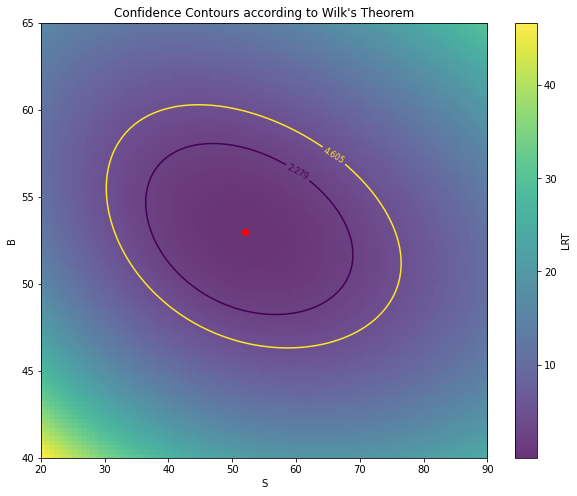

In [18]:
# Now plot the contours of the LRT

S_range = np.linspace(20, 90, 100)  # Range of S values
B_range = np.linspace(40, 65, 100)  # Range of B values

# Create a grid of S and B
S, B = np.meshgrid(S_range, B_range)

lrt_wilk = LRT_Wilk(n_on, n_off, S, B)

plt.figure(figsize=(10, 8))
plt.scatter(S_MLE(n_on, n_off), B_MLE(n_off), c='r')
contour = plt.contour(S, B, lrt_wilk, levels=[t01, t02], cmap="viridis")
plt.clabel(contour, inline=True, fontsize=8)
plt.imshow(lrt_wilk, extent=[S_range.min(), S_range.max(), B_range.min(), B_range.max()],
           origin='lower', aspect='auto', cmap='viridis', alpha=0.8)
plt.colorbar(label='LRT')
plt.title("Confidence Contours according to Wilk's Theorem")
plt.xlabel("S")
plt.ylabel("B")
plt.show()

### 3.3 What is the probability that the true (and forever unknown) parameters (Strue, Btrue) lie inside our CIs? (no calculation needed)

In [19]:
# This is just either 0 or 1, depending if (Strue, Btrue) land inside in our particular CI. Remember that (Strue, Btrue) are parameters and not random variables.